## Geneva Dataset Task Suitability and Exploration
**_Exploration of the dataset and Few-Shot approaches_**

Geneva satellite dataset can be suitable for few-shot segmentation, but it wasn't originally designed for this purpose, and might need some adjustment.

#### Dataset facts:

- It has 1,050 labeled image-mask pairs, which is enough to simulate few-shot scenarios  
- Three distinct categories (all/industrial/residential) let you create meaningful support/query splits  
- Data (images) are geolocated (we have latitude and longitude in the file's name; i.e., "DOP25_LV03_{grid}_{year}_1_15_{x_coord}_{y_coord}.png")
- There is a "Grid" reference as well, but it's not exactly clear what it is (i,e., 1301_11, 1301_13, 1301_31). It should define different part of Geneva, but not clear
- We have labels (pixel-level mask for segmentation) for all the images (we will pretend we don't for the few-shot task)
- The segmentation task is well-defined: rooftop vs background is a clear binary problem  
- Real-world policy relevance: solar panel installation assessment is a concrete government use case
- The current 840-train/104-val/106-test split assumes traditional supervised learning

#### Geneva Dataset and Few-Shot Fine-Tuning for Domain Adaptation

- In the dataset, images are already divided into 'residential' and 'industrial' types. The simplest idea is to use a pre-trained model to segment rooftops of residential building, and use few-shot fine-tuning to adapt the model to segment industrial building (with only 3-5 labels). This is an easy task, and can be used as sandbox example. 

- A more complex and interesting scenario is to use a pre-trained model to segment rooftops of a specific area of Geneva (we have coordinates for each image, so even if we don't have a geographical variable we can easily create it, or we can use different grid sections) and use few-shot fine-tuning to adapt the model to segment rooftops of another area, that looks different (we can choose looking at satellite images if working with grid sections is unsuitable). Different parts of the city likely have different characteristics: urban density, building ages, roof types. We would simulate this "scaling to another city" by working at neighbourhood/area level.

#### Few-Shot Learning with this specific dataset

In our dataset, labels exist for every image, but we can pretend they don't during the few-shot phase. The setup would work like this:

**Training Phase (Base Model):**

- Use the full training set (840 images + labels) to learn general rooftop segmentation features &rarr; foundation model

**Few-Shot Evaluation Phase:**

- Randomly select K images from the test set as your "support set" (e.g., K=5 for 5-shot) &rarr; these are the only labels we allow the model to use for adaptation
- Test on the remaining images as "query set"
- The remaining labels are used only for evaluation

We would simulate the scenario in which we explore the question: "We deployed our model to a new city/building type, but we only have budget to label 5 examples. Can we still segment rooftops accurately?"

#### We can include Active Learning 

How to strategically select which 5-10 images to label (the most informative examples), random that labelling randomly?
Two appraoches:

1. Use base model uncertainty to select the most informative K examples (calculate uncertainty with entropy) &rarr; the easiest and probabily most effective for the tutorial
2. Extract features from all target images and select the most diverse using clustering or maximum distance selection (?) 
3. Use both (uncertainy and diverstiy)

#### Exploration of the dataset

The code below downloads the data into the Hugging Face cache and creates a symlink to it in the `data` folder of this branch. The `data` folder is excluded from version control via `.gitignore`.

In [7]:
from huggingface_hub import snapshot_download
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path

# Download the entire dataset
# We create a foder inside the repo
data_dir = Path("data")

dataset_path = snapshot_download(
    repo_id="raphaelattias/overfitteam-geneva-satellite-images",
    repo_type="dataset",
    local_dir=str(data_dir),
    local_dir_use_symlinks=True,
)

print(f"Dataset downloaded to: {dataset_path}")

Fetching ... files: 2111it [00:00, 4570.14it/s] 

Dataset downloaded to: /Users/giocopp/Desktop/Uni/Hertie School/5th Semester/DL/DL-FinalProject/DL-Tutorial-giorgio-exploration/data


Quickly visualize one of the original images at random and its correspective mask (label).

In [8]:
import os
import random

# We load a random image and its corresponding label from the training dataset
images_dir = os.path.join(dataset_path, "train/images/all")
labels_dir = os.path.join(dataset_path, "train/labels/all")

img_name = random.choice([f for f in os.listdir(images_dir) if f.endswith(".png")])
base, ext = os.path.splitext(img_name)

image = Image.open(os.path.join(images_dir, img_name))
label = Image.open(os.path.join(labels_dir, f"{base}_label{ext}"))

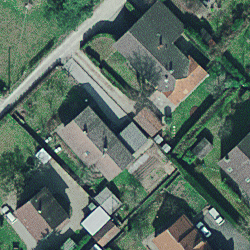

In [9]:
image

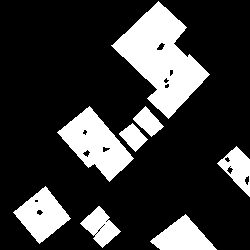

In [10]:
label

In [11]:
# Download dataset once per session

if "dataset_path" not in globals():
    dataset_path = snapshot_download(
        repo_id="raphaelattias/overfitteam-geneva-satellite-images",
        repo_type="dataset",
    )
    print("Dataset cached at:", dataset_path)
else:
    print("Dataset_path already present!", dataset_path)


# Dataset class
class GenevaRooftopDataset(Dataset):
    def __init__(self, split="train", category="all", transform=None, dataset_path=dataset_path):
        """
        Args:
            split (str): 'train', 'val', or 'test'
            category (str): 'all', 'industrial', or 'residencial'
            transform: Optional transform applied to images and labels
            dataset_path (str): Path to the downloaded dataset

        """
        self.split = split
        self.category = category
        self.transform = transform

        self.image_dir = os.path.join(dataset_path, f"{split}/images/{category}")
        self.label_dir = os.path.join(dataset_path, f"{split}/labels/{category}")

        self.images = sorted([f for f in os.listdir(self.image_dir) if f.endswith(".png")])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label_name = img_name.replace(".png", "_label.png")

        image = Image.open(os.path.join(self.image_dir, img_name)).convert("RGB")
        label = Image.open(os.path.join(self.label_dir, label_name))

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label


# Create datasets
train_dataset = GenevaRooftopDataset(split="train", category="all")
val_dataset = GenevaRooftopDataset(split="val", category="all")
test_dataset = GenevaRooftopDataset(split="test", category="all")

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

Dataset_path already present! /Users/giocopp/Desktop/Uni/Hertie School/5th Semester/DL/DL-FinalProject/DL-Tutorial-giorgio-exploration/data
Train samples: 420
Val samples:   52
Test samples:  53


#### Initial Exploration

1. Confirming that the data structure matches the HF description
2. Visualize images and masks from the three categories
3. Basic statistics on pixel fraction coverage for the three categories

In [12]:
### Confirming that the data structure matches the HF description

import matplotlib.pyplot as plt

dataset_root = Path(dataset_path)

splits = ["train", "val", "test"]
categories = ["all", "industrial", "residencial"]

print("Root:", dataset_root)
for split in splits:
    for cat in categories:
        img_dir = dataset_root / split / "images" / cat
        label_dir = dataset_root / split / "labels" / cat
        n_imgs = len([f for f in img_dir.iterdir() if f.suffix == ".png"])
        n_labels = len([f for f in label_dir.iterdir() if f.suffix == ".png"])
        print(f"{split:5s} | {cat:11s} -> images: {n_imgs:4d}, labels: {n_labels:4d}")

Root: /Users/giocopp/Desktop/Uni/Hertie School/5th Semester/DL/DL-FinalProject/DL-Tutorial-giorgio-exploration/data
train | all         -> images:  420, labels:  420
train | industrial  -> images:  199, labels:  199
train | residencial -> images:  221, labels:  221
val   | all         -> images:   52, labels:   52
val   | industrial  -> images:   26, labels:   26
val   | residencial -> images:   26, labels:   26
test  | all         -> images:   53, labels:   53
test  | industrial  -> images:   28, labels:   28
test  | residencial -> images:   25, labels:   25


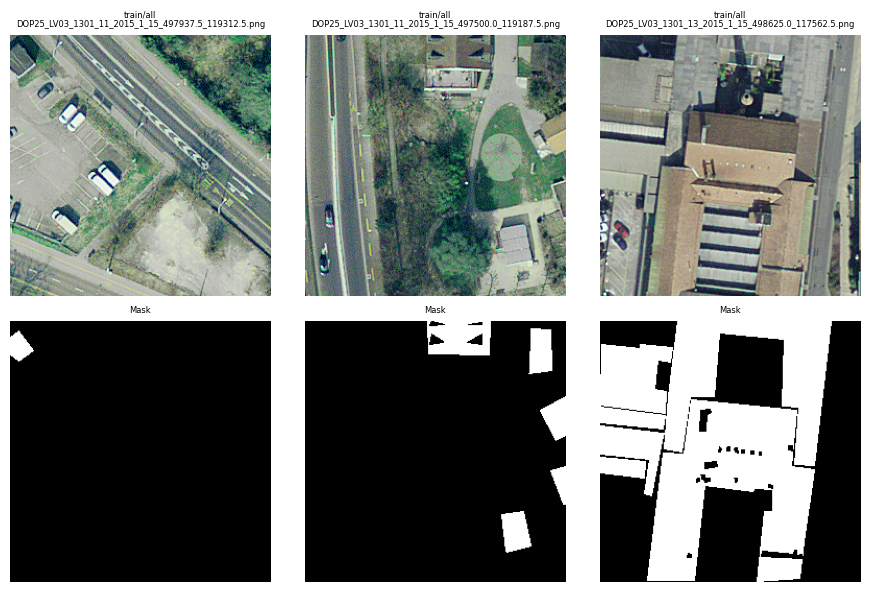

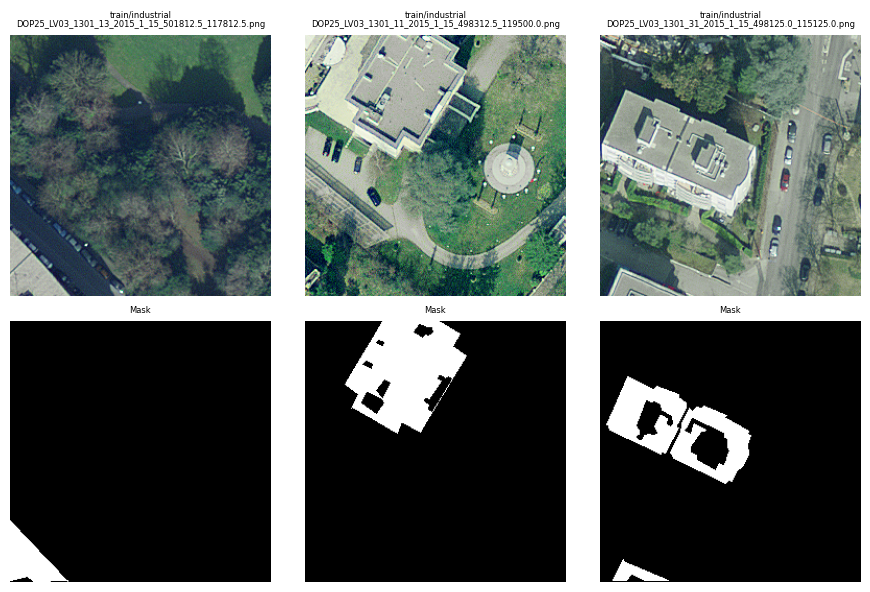

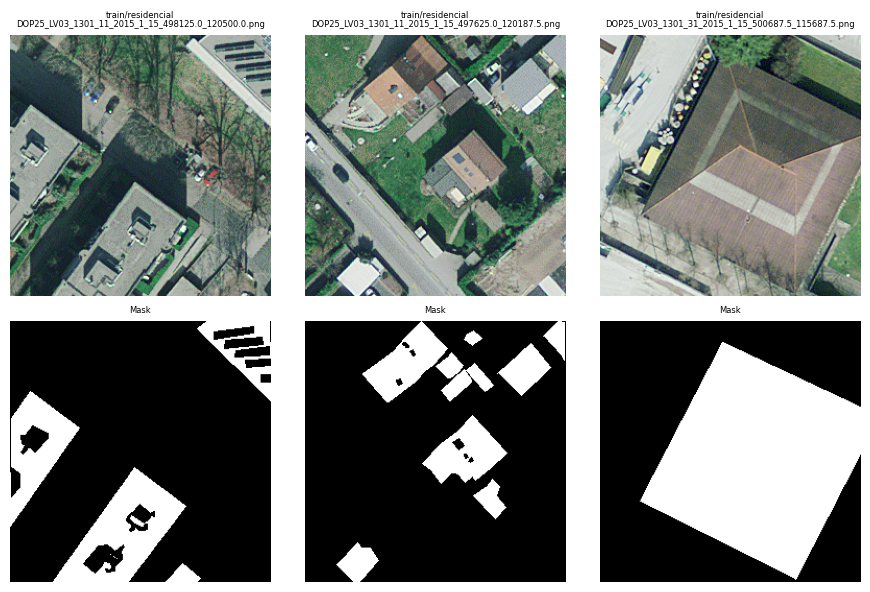

In [13]:
### Visualize images and masks from the three categories

dataset_root = Path(dataset_path)


def show_random_samples(split="train", category="all", n=3):
    img_dir = dataset_root / split / "images" / category
    label_dir = dataset_root / split / "labels" / category

    image_files = sorted([f for f in img_dir.iterdir() if f.suffix == ".png"])
    if len(image_files) == 0:
        raise ValueError(f"No images found in {img_dir}")

    chosen = random.sample(image_files, k=min(n, len(image_files)))

    plt.figure(figsize=(3 * n, 6))
    for i, img_path in enumerate(chosen):
        base = img_path.stem
        label_path = label_dir / f"{base}_label.png"

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path)

        plt.subplot(2, n, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{split}/{category}\n{img_path.name}", fontsize=6)

        plt.subplot(2, n, n + i + 1)
        plt.imshow(label)
        plt.axis("off")
        plt.title("Mask", fontsize=6)

    plt.tight_layout()
    plt.show()


# Now this works:
show_random_samples(split="train", category="all", n=3)
show_random_samples(split="train", category="industrial", n=3)
show_random_samples(split="train", category="residencial", n=3)

In [14]:
### Basic statistics on pixel fraction coverage for the three categories

import numpy as np


def compute_basic_stats(split="train", category="all", max_images=100):
    img_dir = dataset_root / split / "images" / category
    label_dir = dataset_root / split / "labels" / category

    image_files = sorted([f for f in img_dir.iterdir() if f.suffix == ".png"])
    if len(image_files) == 0:
        raise ValueError(f"No images found in {img_dir}")

    image_files = image_files[:max_images]

    sizes = []
    rooftop_fracs = []

    for img_path in image_files:
        base = img_path.stem
        label_path = label_dir / f"{base}_label.png"

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path)

        sizes.append(image.size)  # (width, height)

        # Convert mask to numpy, assume rooftop pixels are non-zero
        m = np.array(label)
        rooftop_frac = (m > 0).mean()
        rooftop_fracs.append(rooftop_frac)

    # still computed, but not printed repeatedly
    widths, heights = zip(*sizes, strict=False)

    rooftop_fracs = np.array(rooftop_fracs)
    n_images = len(image_files)

    mean_rf = rooftop_fracs.mean()
    median_rf = np.median(rooftop_fracs)
    min_rf = rooftop_fracs.min()
    max_rf = rooftop_fracs.max()

    print()
    print(f"Rooftop pixel fraction stats for {split}/{category} (n={n_images}):")
    print(f"  mean   : {mean_rf:.3f}")
    print(f"  median : {median_rf:.3f}")
    print(f"  min    : {min_rf:.3f}")
    print(f"  max    : {max_rf:.3f}")
    print("-" * 40)

    return {
        "sizes": sizes,
        "rooftop_fracs": rooftop_fracs,
    }


_ = compute_basic_stats("train", "all")
_ = compute_basic_stats("train", "industrial")
_ = compute_basic_stats("train", "residencial")


Rooftop pixel fraction stats for train/all (n=100):
  mean   : 0.148
  median : 0.134
  min    : 0.007
  max    : 0.603
----------------------------------------

Rooftop pixel fraction stats for train/industrial (n=100):
  mean   : 0.204
  median : 0.158
  min    : 0.001
  max    : 0.972
----------------------------------------

Rooftop pixel fraction stats for train/residencial (n=100):
  mean   : 0.125
  median : 0.122
  min    : 0.004
  max    : 0.347
----------------------------------------


**Comment:** Industrial images contain substantially more rooftop area (and some almost entirely rooftop) than residential images, which show lower and less variable rooftop coverage. 

#### Geo-reference Exploration

4. Check grid reference.  

    Considering a filename: `DOP25_LV03_1301_11_2015_1_15_497500.0_119062.5.png`, we have  
    - `DOP25` – product / dataset name (likely “digital orthophoto 25 cm” or similar).
    - `LV03` – Swiss national coordinate system CH1903 / LV03 (old Swiss grid). 
    - `1301` – map sheet number: Swisstopo national topographic map 1:25 000, sheet 1301 “Genève”. 
    - `11` – a sub-grid / tile index inside that sheet (your dataset uses 1301_11, 1301_13, 1301_31, etc. as examples).
    - `2015` – year of the imagery.
    - `1` / `15` – campaign / flight / tiling parameters (ignore).
    - `497500.0` / `119062.5` – LV03 coordinates (eastings / northings in meters) of the tile (centre or corner).

    Gird reference `1301_11` reads as: "which Swisstopo map sheet (1301 = Genève) and which sub-tile (11) the patch comes from".  
    _Rationale_: We could for example train on some grids and test on others to simulate domain shift within Geneva

5. Print images on a map grouped by grid reference.  
    Use OMS to plot

In [15]:
### Counting images per grid and category

from pathlib import Path
from collections import Counter

dataset_path = Path(dataset_path)  # make sure it's a Path


def parse_grid_from_name(path: Path):
    parts = path.stem.split("_")
    sheet, subgrid = parts[2], parts[3]  # 1301, 11
    return f"{sheet}_{subgrid}"


splits = ["train", "val", "test"]
categories = ["all", "industrial", "residencial"]

for split in splits:
    # First pass: collect grids for this split to know all columns
    split_cat_files = {}
    split_cat_grids = {}
    all_grids = set()

    for cat in categories:
        img_dir = dataset_path / split / "images" / cat
        files = sorted(img_dir.glob("*.png"))
        if not files:
            continue
        grids = [parse_grid_from_name(f) for f in files]
        split_cat_files[cat] = files
        split_cat_grids[cat] = grids
        all_grids.update(grids)

    if not split_cat_files:
        continue

    grid_ids = sorted(all_grids)

    # Print header
    print(f"\n=== {split.upper()} ===")
    header = "category    | total | " + " | ".join(f"{gid:>11}" for gid in grid_ids)
    print(header)
    print("-" * len(header))

    # Rows per category
    for cat in categories:
        if cat not in split_cat_files:
            continue
        files = split_cat_files[cat]
        total = len(files)
        counts = Counter(split_cat_grids[cat])

        cells = []
        for gid in grid_ids:
            n = counts.get(gid, 0)
            if n == 0:
                cell = "-"
            else:
                pct = n / total * 100
                cell = f"{n} ({pct:.1f}%)"
            cells.append(f"{cell:>11}")

        row = f"{cat:<11} | {total:5d} | " + " | ".join(cells)
        print(row)


=== TRAIN ===
category    | total |     1301_11 |     1301_13 |     1301_31
-------------------------------------------------------------
all         |   420 | 295 (70.2%) |  76 (18.1%) |  49 (11.7%)
industrial  |   199 | 117 (58.8%) |  62 (31.2%) |  20 (10.1%)
residencial |   221 | 178 (80.5%) |   14 (6.3%) |  29 (13.1%)

=== VAL ===
category    | total |     1301_11 |     1301_13 |     1301_31
-------------------------------------------------------------
all         |    52 |  35 (67.3%) |  10 (19.2%) |   7 (13.5%)
industrial  |    26 |  16 (61.5%) |   5 (19.2%) |   5 (19.2%)
residencial |    26 |  19 (73.1%) |   5 (19.2%) |    2 (7.7%)

=== TEST ===
category    | total |     1301_11 |     1301_13 |     1301_31
-------------------------------------------------------------
all         |    53 |  34 (64.2%) |  16 (30.2%) |    3 (5.7%)
industrial  |    28 |  18 (64.3%) |  10 (35.7%) |           -
residencial |    25 |  16 (64.0%) |   6 (24.0%) |   3 (12.0%)


In [16]:
### Mapping image locations by grid

%pip install pyproj folium

from pathlib import Path
from collections import defaultdict
from pyproj import Transformer

dataset_path = Path(dataset_path)

# LV03 (CH1903) -> WGS84
transformer = Transformer.from_crs("EPSG:21781", "EPSG:4326", always_xy=True)


def parse_from_name(path: Path):
    # Example: DOP25_LV03_1301_11_2015_1_15_497500.0_119062.5.png
    parts = path.stem.split("_")
    sheet = parts[2]  # "1301"
    subgrid = parts[3]  # "11"
    year = int(parts[4])  # 2015
    e = float(parts[-2])  # LV03 easting
    n = float(parts[-1])  # LV03 northing
    grid_id = f"{sheet}_{subgrid}"
    return grid_id, year, e, n


split = "train"  # change here to "val" or "test" as needed
category = "all"  # change here to "industrial" or "residencial" as needed
img_dir = dataset_path / split / "images" / category

grid_points = defaultdict(list)  # grid_id -> list of (lat, lon)

for f in sorted(img_dir.glob("*.png")):
    grid_id, year, e, n = parse_from_name(f)
    lon, lat = transformer.transform(e, n)  # LV03 -> WGS84
    grid_points[grid_id].append((lat, lon))

Note: you may need to restart the kernel to use updated packages.


In [17]:
### Visualizing image locations on a map

import folium
import itertools

# 1) Compute map center
all_points = [pt for pts in grid_points.values() for pt in pts]
lats = [p[0] for p in all_points]
lons = [p[1] for p in all_points]

center_lat = float(np.mean(lats))
center_lon = float(np.mean(lons))

# 2) Assign one color per grid
color_cycle = itertools.cycle(["red", "blue", "green"])
grid_colors = {gid: next(color_cycle) for gid in sorted(grid_points.keys())}

# 3) Create map and add points
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

for grid_id, pts in grid_points.items():
    color = grid_colors[grid_id]
    for lat, lon in pts:
        folium.CircleMarker(
            location=(lat, lon),
            radius=2,
            popup=f"Grid: {grid_id}",
            color=color,
            opacity=0.8,
            fill=True,
            fill_color=color,
            fill_opacity=0.2,
        ).add_to(m)

# 4) Add legend (simple HTML overlay)
legend_items = ""
for gid, color in grid_colors.items():
    legend_items += f"""
    <div style="margin-bottom:2px;">
      <span style="display:inline-block;width:10px;height:10px;
                   border-radius:50%;background:{color};
                   margin-right:6px;"></span>
      <span>{gid}</span>
    </div>
    """

legend_html = f"""
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    z-index: 9999;
    background-color: white;
    padding: 8px 10px;
    border: 1px solid #999;
    border-radius: 4px;
    box-shadow: 0 0 4px rgba(0,0,0,0.3);
    font-size: 12px;
">
  <b>Grids</b><br>
  {legend_items}
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))

m